In [7]:
%matplotlib inline
%load_ext rpy2.ipython

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn import preprocessing

import warnings

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ISO 5017. 

1. Measure temperature of liquid to determine its ($\rho_{\text{liq}}$) and find object theoretical full density ( $\rho_{\text{solid}}$ ) from datasheet
2. Measure mass of sample(s) in air ($m_1$)
3. Impregnate sample(s) in fluid (Isopropanol) 
4. Measure mass of wet sample(s) suspended in fluid ($m_2$)
5. Remove sample from balance and measure mass of soaked piece ($m_3$)

\begin{equation}
    \text{bulk density}, \rho_b = \frac{m_1}{m_3-m_2}*\rho_{\text{liq}}
\end{equation}

\begin{equation}
    \text{true density}, \pi_d = \frac{ \rho_b}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Load Data from excel sheet

In [8]:
data = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'archimedes', index_col= [0,1])
iso_density = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'arch_param', index_col= 0)

## Display first few row of excel sheet

In [9]:
data.head()

powder type  dry weight  wet coated  coated weight  exp  operator
batch ID                                                                    
4     3.0     Unimodal     14.8038     13.2572        15.9512    1         1
      3.0     Unimodal     14.7935     13.2525        15.9485    1         1
      8.0     Unimodal     15.2090     13.6240        16.3252    1         1
      8.0     Unimodal     15.2038     13.6184        16.3211    1         1
      14.0    Unimodal     15.3370     13.7548        16.4814    1         1

## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{liq}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

In [10]:
iso_density

,density isopropanol
exp,
1,0.7842
2,0.7842
2,0.7838


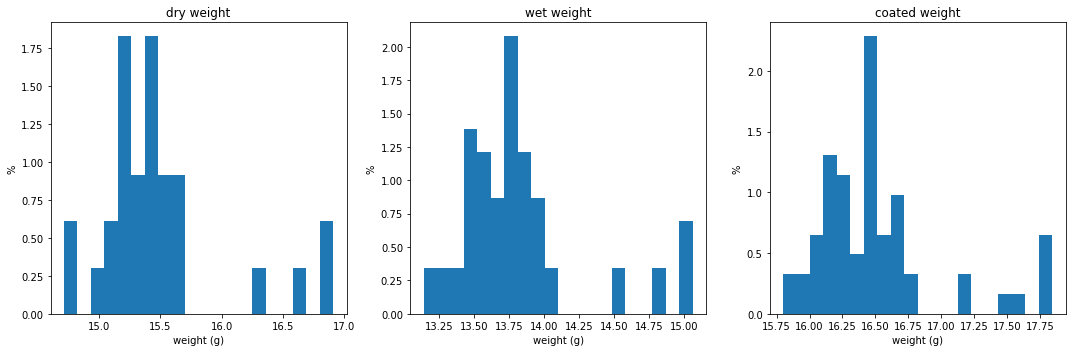

In [11]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3, figsize = (15,5))
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')
    
    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_t$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [12]:
density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]

    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    # density of liquid taken from datasheet
    iso_den = iso_density.loc[exp_num].to_numpy()
    
    # cartesian product
    prod = product(d_weight, wc_weight, c_weight, iso_den)

    for d_w, wc_w, c_w, iso_d in prod:
        #compute true density refer to equation on top
        den = (d_w/(c_w - wc_w)*iso_d)/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

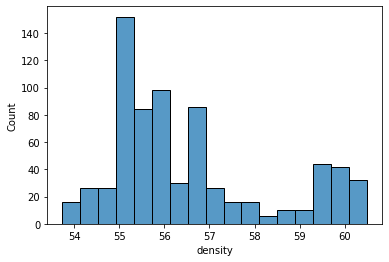

In [13]:
ax = sns.histplot(density_df['density'])

In [14]:
density_df.to_csv('./data/density_archimedes.csv', index=False)

In [15]:
density_df.head()

,batch,id,density,operator,powder
0,4,0,53.865720,1,Unimodal
1,4,0,53.865720,1,Unimodal
2,4,0,53.919760,1,Unimodal
3,4,0,53.919760,1,Unimodal
4,4,0,53.771909,1,Unimodal


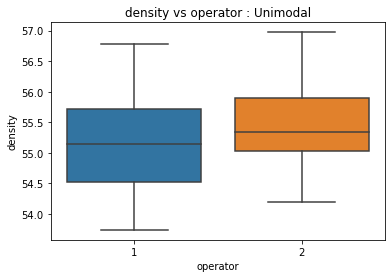

In [16]:
unimodal_df = density_df[density_df['powder'] == 'Unimodal']
fig, ax = plt.subplots()
ax.set_title('density vs operator : Unimodal')
sns.boxplot(x = 'operator', y ='density', data = unimodal_df, ax = ax)
plt.show()

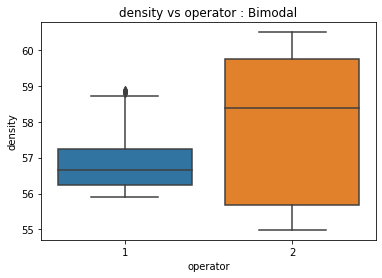

In [17]:
bimodal_df = density_df[density_df['powder'] == 'Bimodal']
fig, ax = plt.subplots()
ax.set_title('density vs operator : Bimodal')
sns.boxplot(x = 'operator', y ='density', data = bimodal_df, ax = ax)
plt.show()

In [21]:
%%R -i density_df




NULL
